In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from tqdm.notebook import tqdm

import torch
import torch.distributions as dist

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy, UnwhitenedVariationalStrategy
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

from pymc3.gp.util import plot_gp_dist

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
# Set seed
np.random.seed(123)

# Create data based on population statistics

In [4]:
content = ([
    [40, 98, 125, 133, 151, 162],
    [46, 103, 130, 138, 156, 167],
    [48, 107, 135, 145, 164, 173],
    [50, 112, 141, 152, 172, 180],
    [52, 116, 148, 159, 180, 186],
    [54, 120, 153, 167, 188, 192],
    [60, 125, 158, 172, 193, 197]
])

index = [0.00, 0.025, 0.16, 0.50, 0.84, 0.975, 1.00]

ages = np.array([0, 5, 10, 12, 15, 20])

data = pd.DataFrame(content, columns=ages, index=index)
data.index.name = r"P(Y < y)"
data

,0,5,10,12,15,20
P(Y < y),,,,,,
0.000,40,98,125,133,151,162
0.025,46,103,130,138,156,167
0.160,48,107,135,145,164,173
0.500,50,112,141,152,172,180
0.840,52,116,148,159,180,186
0.975,54,120,153,167,188,192
1.000,60,125,158,172,193,197


In [5]:
data = data.T
data

P(Y < y),0.000,0.025,0.160,0.500,0.840,0.975,1.000
0,40,46,48,50,52,54,60
5,98,103,107,112,116,120,125
10,125,130,135,141,148,153,158
12,133,138,145,152,159,167,172
15,151,156,164,172,180,188,193
20,162,167,173,180,186,192,197


In [6]:
y_err = np.abs(data[[0.160, 0.840]].values.T - data[0.500].values.T)

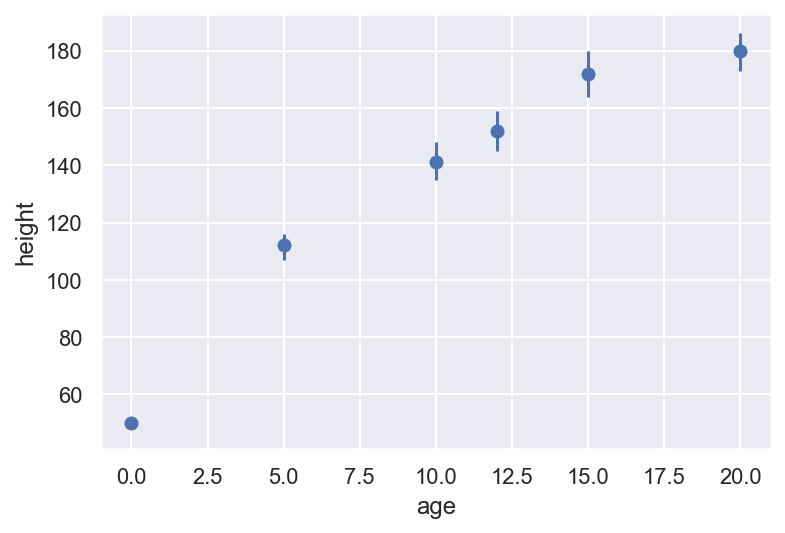

In [7]:
fig, ax = plt.subplots()
ax.errorbar(x=ages, y=data[0.500], yerr=y_err, fmt="o")
ax.set_xlabel("age")
ax.set_ylabel("height");

In [8]:
pop_param = data

In [9]:
np.random.seed(123)

obs_age = []
obs_height = []

n_per_group = 100
for a in ages:
    obs_height += list(np.random.normal(pop_param.loc[a, 0.500], 
                                        pop_param.loc[a, 0.840]-pop_param.loc[a, 0.500],
                                        size=n_per_group))
    obs_age += [a, ] * n_per_group

data = pd.DataFrame({"age": obs_age, "height": obs_height})
data

,age,height
0,0,47.828739
1,0,51.994691
2,0,50.565957
3,0,46.987411
4,0,48.842799
...,...,...
595,20,181.652051
596,20,176.216290
597,20,171.633749
598,20,185.476128


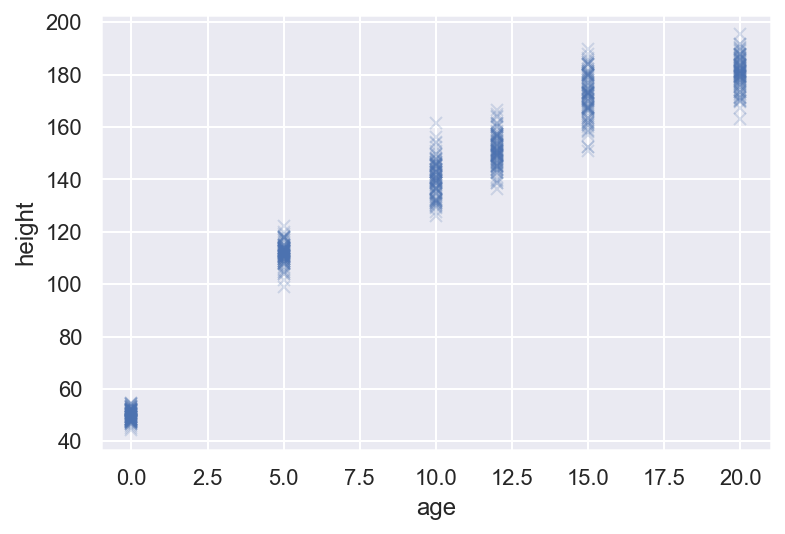

In [10]:
fig, ax = plt.subplots()
ax.plot(data.age, data.height, "x", alpha=0.2)
ax.set_xlabel("age")
ax.set_ylabel("height");

# Fit models (point estimate)

In [11]:
MAX = np.log(np.finfo(float).max)

def safe_exp(x):
    return np.exp(np.clip(x, -np.inf, MAX))

## Linear function (Linf)

In [12]:
class Linf:
    
    @staticmethod
    def forward(t, param):
        
        beta0, beta1 = param
        pred = beta0 + beta1*t
        return pred
   
    @classmethod
    def loss(cls, param):

        pred = cls.forward(data.age, param)
        return np.sum((data.height - pred)**2)
    

In [13]:
res_linf = scipy.optimize.minimize(fun=Linf.loss, x0=np.ones(2), method='BFGS')

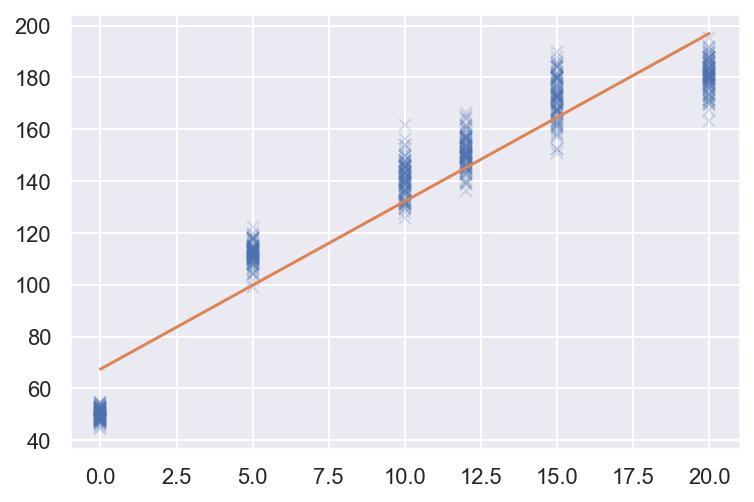

In [14]:
x_plot = np.linspace(0, 20, 100)
pred_linf = Linf.forward(x_plot, res_linf.x)

fig, ax = plt.subplots()
ax.plot(data.age, data.height, 'x', alpha=0.2)
ax.plot(x_plot, pred_linf, color="C1");

## Logistic function (Logf)

In [15]:
class Logf:
    
    @staticmethod
    def forward(t, param):
        
        unc_t0, unc_h1, unc_k = param
        
        t0 = safe_exp(unc_t0)
        h1 = safe_exp(unc_h1)
        k = safe_exp(unc_k)
        pred = h1 / (1 + safe_exp(-k*(t-t0)))
        return pred
   
    @classmethod
    def loss(cls, param):

        pred = cls.forward(data.age, param)
        return np.sum((data.height - pred)**2)

In [16]:
res_logf = scipy.optimize.minimize(fun=Logf.loss, x0=np.ones(3), method='BFGS')

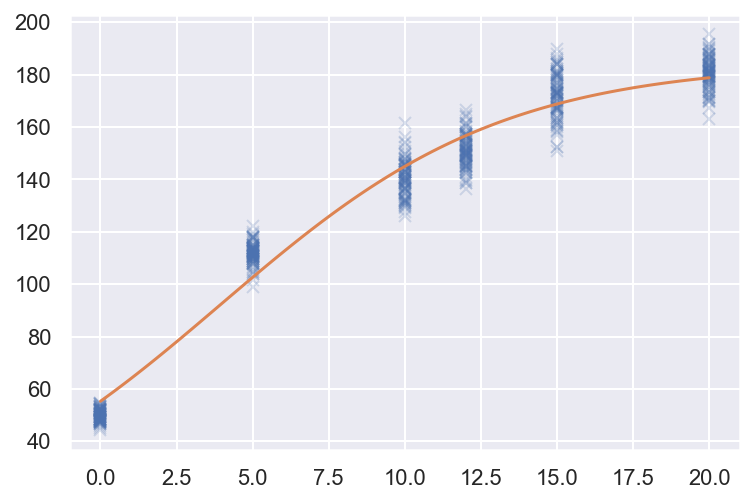

In [17]:
x_plot = np.linspace(0, 20, 100)
pred_logf = Logf.forward(x_plot, res_logf.x)

fig, ax = plt.subplots()
ax.plot(data.age, data.height, "x", alpha=0.2)
ax.plot(x_plot, pred_logf, color="C1");

## Preece and Baines (Pb)

M. Preece and M. Baines. A new family of mathematical models describing the human growth curve. Annals of human biology, 5(1):1–24, 1978.

In [18]:
class Pb:
    
    @staticmethod
    def forward(t, param):
        
        unc_h1, unc_h_star, unc_t_star, unc_s0, unc_s1 = param
        
        h1 = np.log(1+safe_exp(unc_h1))
        h_star = np.log(1+safe_exp(unc_h_star))
        t_star = np.log(1+safe_exp(unc_t_star))
        s0 = np.log(1+safe_exp(unc_s0))
        s1 = np.log(1+safe_exp(unc_s1))
        
        delta_t = t-t_star
        
        pred = h1 - 2 * (h1 - h_star) / ( safe_exp(s0*delta_t) + safe_exp(s1*delta_t) )
        return pred
   
    @classmethod
    def loss(cls, param):

        pred = cls.forward(data.age, param)
        return np.sum((data.height - pred)**2)

In [19]:
res_pb = scipy.optimize.minimize(fun=Pb.loss, x0=np.ones(5), method='BFGS')

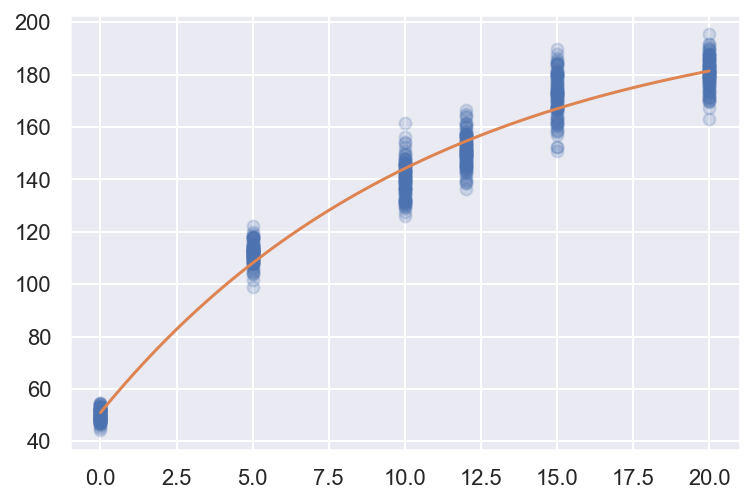

In [20]:
x_plot = np.linspace(0, 20, 100)
pred_pb = Pb.forward(x_plot, res_pb.x)

fig, ax = plt.subplots()
ax.scatter(data.age, data.height, alpha=0.2)
ax.plot(x_plot, pred_pb, color="C1");

## Jolicoeur, Pontier, Pernin and Sempé (Jpps)

P. Jolicoeur, J. Pontier, M.-O. Pernin, and M. Sempé. A lifetime asymptotic
growth curve for human height. Biometrics, pages 995–1003, 1988.

In [21]:
class Jpps:
    
    @staticmethod
    def forward(t, param):
        
        unc_h1, unc_C1, unc_C2, unc_C3, unc_D1, unc_D2, unc_D3 = param
        
        h1 = safe_exp(unc_h1)
        C1 = safe_exp(unc_C1)
        C2 = safe_exp(unc_C2)
        C3 = safe_exp(unc_C3)
        D1 = safe_exp(unc_D1)
        D2 = safe_exp(unc_D2)
        D3 = safe_exp(unc_D3)
        
        tp = t + 0.75 
        
        pred = h1 * (1 - 1 / ( 1 +  (tp / D1)**C1 + (tp / D2)**C2 + (tp / D3)**C3 ) )
        return pred
   
    @classmethod
    def loss(cls, param):

        pred = cls.forward(data.age, param)
        return np.sum((data.height - pred)**2)

In [22]:
res_jpps = scipy.optimize.minimize(fun=Jpps.loss, x0=np.ones(7), method="BFGS")

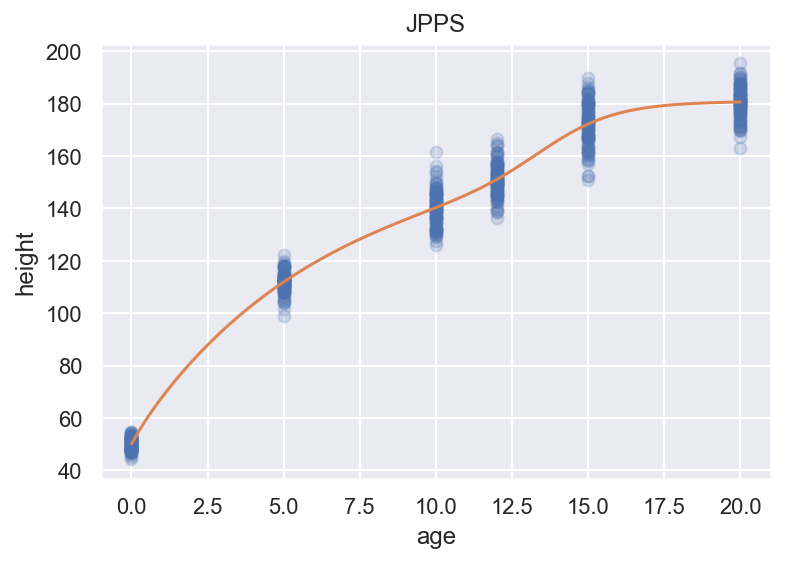

In [23]:
x_plot = np.linspace(0, 20, 100)
pred_jpps = Jpps.forward(x_plot, res_jpps.x)

fig, ax = plt.subplots()
ax.scatter(data.age, data.height, alpha=0.2)
ax.set_title("JPPS")
ax.plot(x_plot, pred_jpps, color="C1")
ax.set_xlabel("age")
ax.set_ylabel("height");

## Shohoji-Sasaki modified by Cole (SSC) 

T. Cole. The use and construction of anthropometric growth reference standards.
Nutrition research reviews, 6(1):19–50, 1993.

In [24]:
class Ssc:
    
    @staticmethod
    def forward(t, param):
        
        unc_h1, unc_k, beta0, beta1, unc_c, unc_r, unc_t_star = param
        
        h1 = safe_exp(unc_h1)
        k = safe_exp(unc_k)
        c = safe_exp(unc_c)
        r = safe_exp(unc_r)
        t_star = safe_exp(unc_t_star)
        
        Wt = safe_exp(-safe_exp(k*(t_star - t)))
        
        ft = beta0 + beta1*t - safe_exp(c-r*t)
        pred = 0.1 * (h1*Wt + ft*(1 - Wt))
        return pred
   
    @classmethod
    def loss(cls, param):

        pred = cls.forward(data.age, param)
        return np.sum((data.height - pred)**2)

In [25]:
res_ssc = scipy.optimize.minimize(fun=Ssc.loss, x0=np.ones(7), method="BFGS")

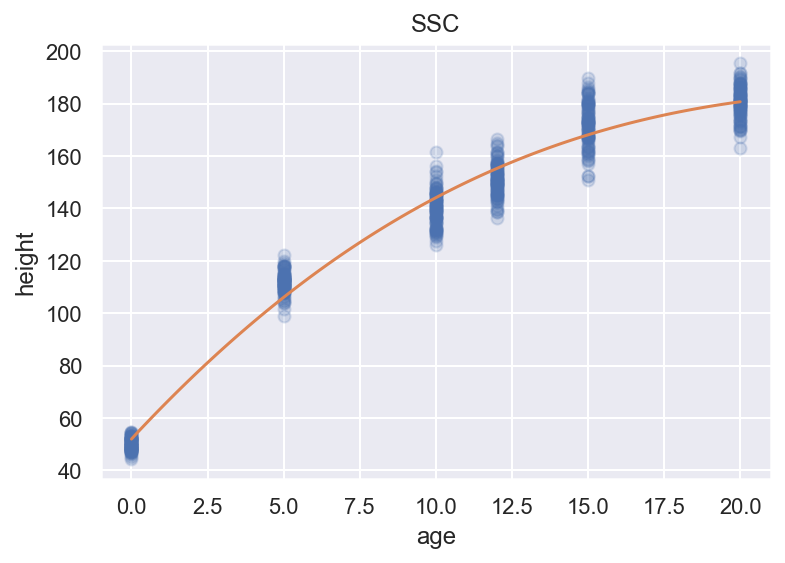

In [26]:
x_plot = np.linspace(0, 20, 100)
pred_ssc = Ssc.forward(x_plot, res_ssc.x)

fig, ax = plt.subplots()
ax.scatter(data.age, data.height, alpha=0.2)
ax.plot(x_plot, pred_ssc, color="C1")
ax.set_title("SSC")
ax.set_xlabel("age")
ax.set_ylabel("height");

# Using 'textbook' GP

In [27]:
class GPModel(gpytorch.models.ExactGP):
    """
    straight from the doc
    """
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [28]:
def train_gp(data, epochs=100):
    
    # extract data
    train_x = torch.from_numpy(data.age.values).double()
    train_y = torch.from_numpy(data.height.values).double()
    
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    gp = GPModel(train_x, train_y, likelihood=likelihood)

    # Find optimal model hyperparameters
    gp.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(gp.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

    hist_loss = []

    with tqdm(total=epochs) as pbar:
        for i in range(epochs):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = gp(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()

            optimizer.step()

            pbar.update()
            pbar.set_postfix({"loss": loss.item()})
    return gp, likelihood, hist_loss

In [32]:
def plot_gp(data, model, likelihood):
    
    # extract data
    train_x = torch.from_numpy(data.age.values).double()
    train_y = torch.from_numpy(data.height.values).double()
    
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(0, data.age.max(), 50).double()
        observed_pred = likelihood(model(test_x))

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(figsize=(10, 7))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'C0')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)

        ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [33]:
model, likelihood, hist_loss = train_gp(data)

  0%|          | 0/100 [00:00<?, ?it/s]

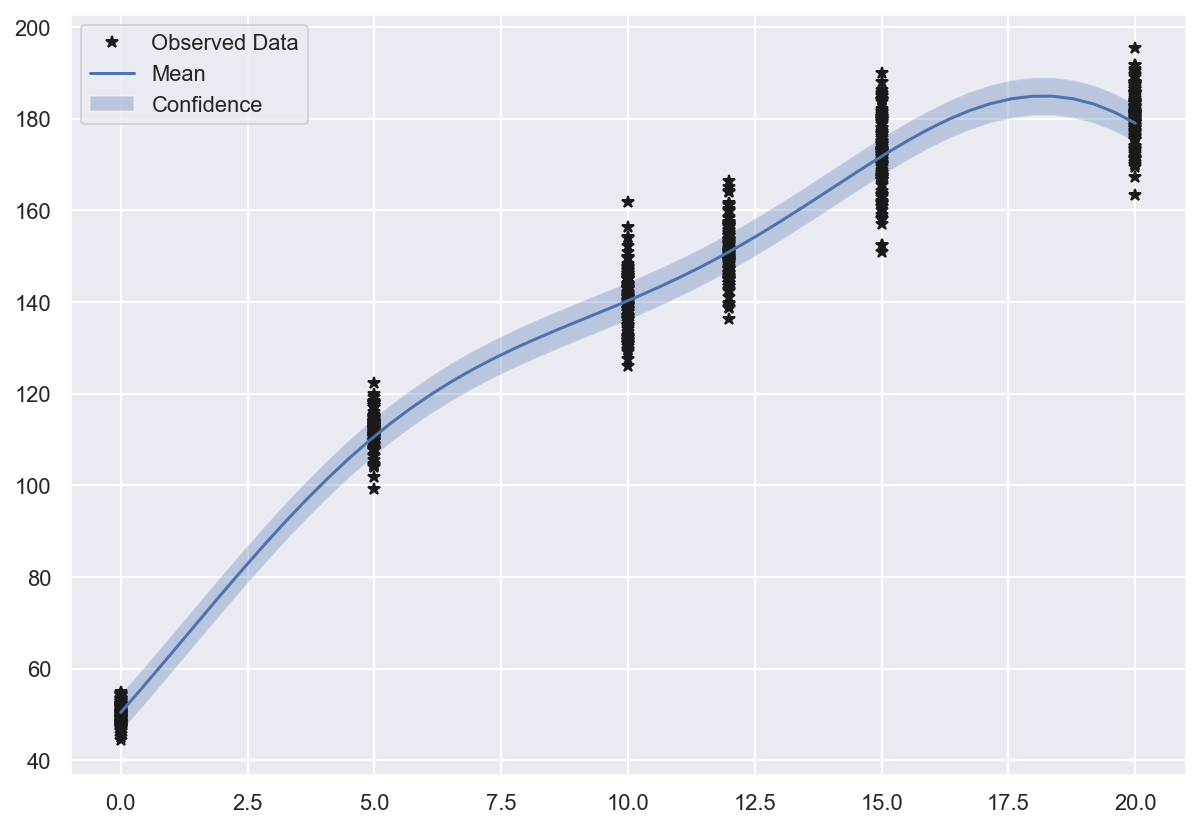

In [34]:
plot_gp(data, model, likelihood)

# Model discrepancy

In [35]:
class MeanFunc(gpytorch.means.mean.Mean):
    
    def __init__(self, m, theta):
        super().__init__()
        self.m = m
        self.theta = theta
    
    def forward(self, x):
        return self.m.forward(x.squeeze(-1), self.theta)  

In [36]:
class DiscrepancyModel(gpytorch.models.ExactGP):
    
    def __init__(self, train_x, train_y, likelihood, m, theta):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = MeanFunc(m=m, theta=theta)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [37]:
def train_discrepancy_model(data, m, theta, epochs=100):
    
    # extract data
    train_x = torch.from_numpy(data.age.values).double()
    train_y = torch.from_numpy(data.height.values).double()
    
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = DiscrepancyModel(train_x, train_y, likelihood, m, theta)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    hist_loss = []

    with tqdm(total=epochs) as pbar:
    
    for i in range(epochs):
            
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            
            # Output from model
            output = model(train_x)
            
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()
            
            # Update progress bar
            pbar.update()
            pbar.set_postfix({"loss": loss.item()})
    
    return model, likelihood, hist_loss

In [116]:
def plot_discrepancy(data, model, likelihood, m, theta, title=None):
    
    # extract data
    train_x = data.age.values
    train_y = data.height.values
    
    # Pickup testing points        
    test_x = torch.linspace(0, train_x.max(), 50).double()
    
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():

        # Make predictions by feeding model through likelihood
        observed_pred = likelihood(model(test_x))
        
        # Get upper and lower confidence bounds
        gp_lower, gp_upper = observed_pred.confidence_region()
        gp_lower = gp_lower.numpy()
        gp_upper = gp_upper.numpy()
        
        # Get mean
        gp_mean = observed_pred.mean.numpy()
        
        # Convert to numpy for plot
        test_x = test_x.numpy()
        
        # Get model predictions
        m_pred = m.forward(test_x, theta)
        
        # Initialize plot
        f, axes = plt.subplots(figsize=(20, 7), ncols=2)
        
        # On the first axis...
        ax = axes[0]
        
        # Plot training data as black stars
        h_obs, = ax.plot(train_x, train_y, 'k*', label='Observed data')
        # Plot predictive means as blue line
        h_mean, = ax.plot(test_x, gp_mean, 'C0', label="Model + correction - Mean")
        # Shade between the lower and upper confidence bounds
        h_conf = ax.fill_between(test_x, gp_lower, gp_upper, alpha=0.3, label="Model + correction - Confidence")
        
        # Plot model predictions
        h_model = ax.plot(test_x, m_pred, color='C1', ls="--", label="Model alone")
        
        # Add legend / title / format axis
        ax.legend(handles=[h_obs, h_mean, h_conf ],)
        ax.set_xlabel("age")
        ax.set_ylabel("height")
        ax.set_title(title)
        
        # On the second axis...
        ax = axes[1]
        
        # Add horizontal line
        ax.hlines(y=0, ls="--", xmin=test_x.min(), xmax=test_x.max(), color="black")
        
        # Compute correction
        corr = gp_mean - m_pred 
        corr_lower = gp_lower - m_pred
        corr_upper = gp_upper - m_pred
        
        # Plot correction and CI
        ax.plot(test_x, corr, 'C0', label="Correction - Mean")
        ax.fill_between(test_x, corr_lower, corr_upper, alpha=0.3, label="Correction - Confidence")
        
        # Add legend / title / format axis
        ax.set_xlabel("age")
        ax.set_ylabel("correction (height)")
        ax.legend()
        ax.set_title(title)
        
    return fig, ax

## Using JPPS

In [103]:
m = Jpps
theta = res_jpps.x

In [104]:
model, likelihood, hist_loss = train_discrepancy_model(data, m, theta)

  0%|          | 0/100 [00:00<?, ?it/s]

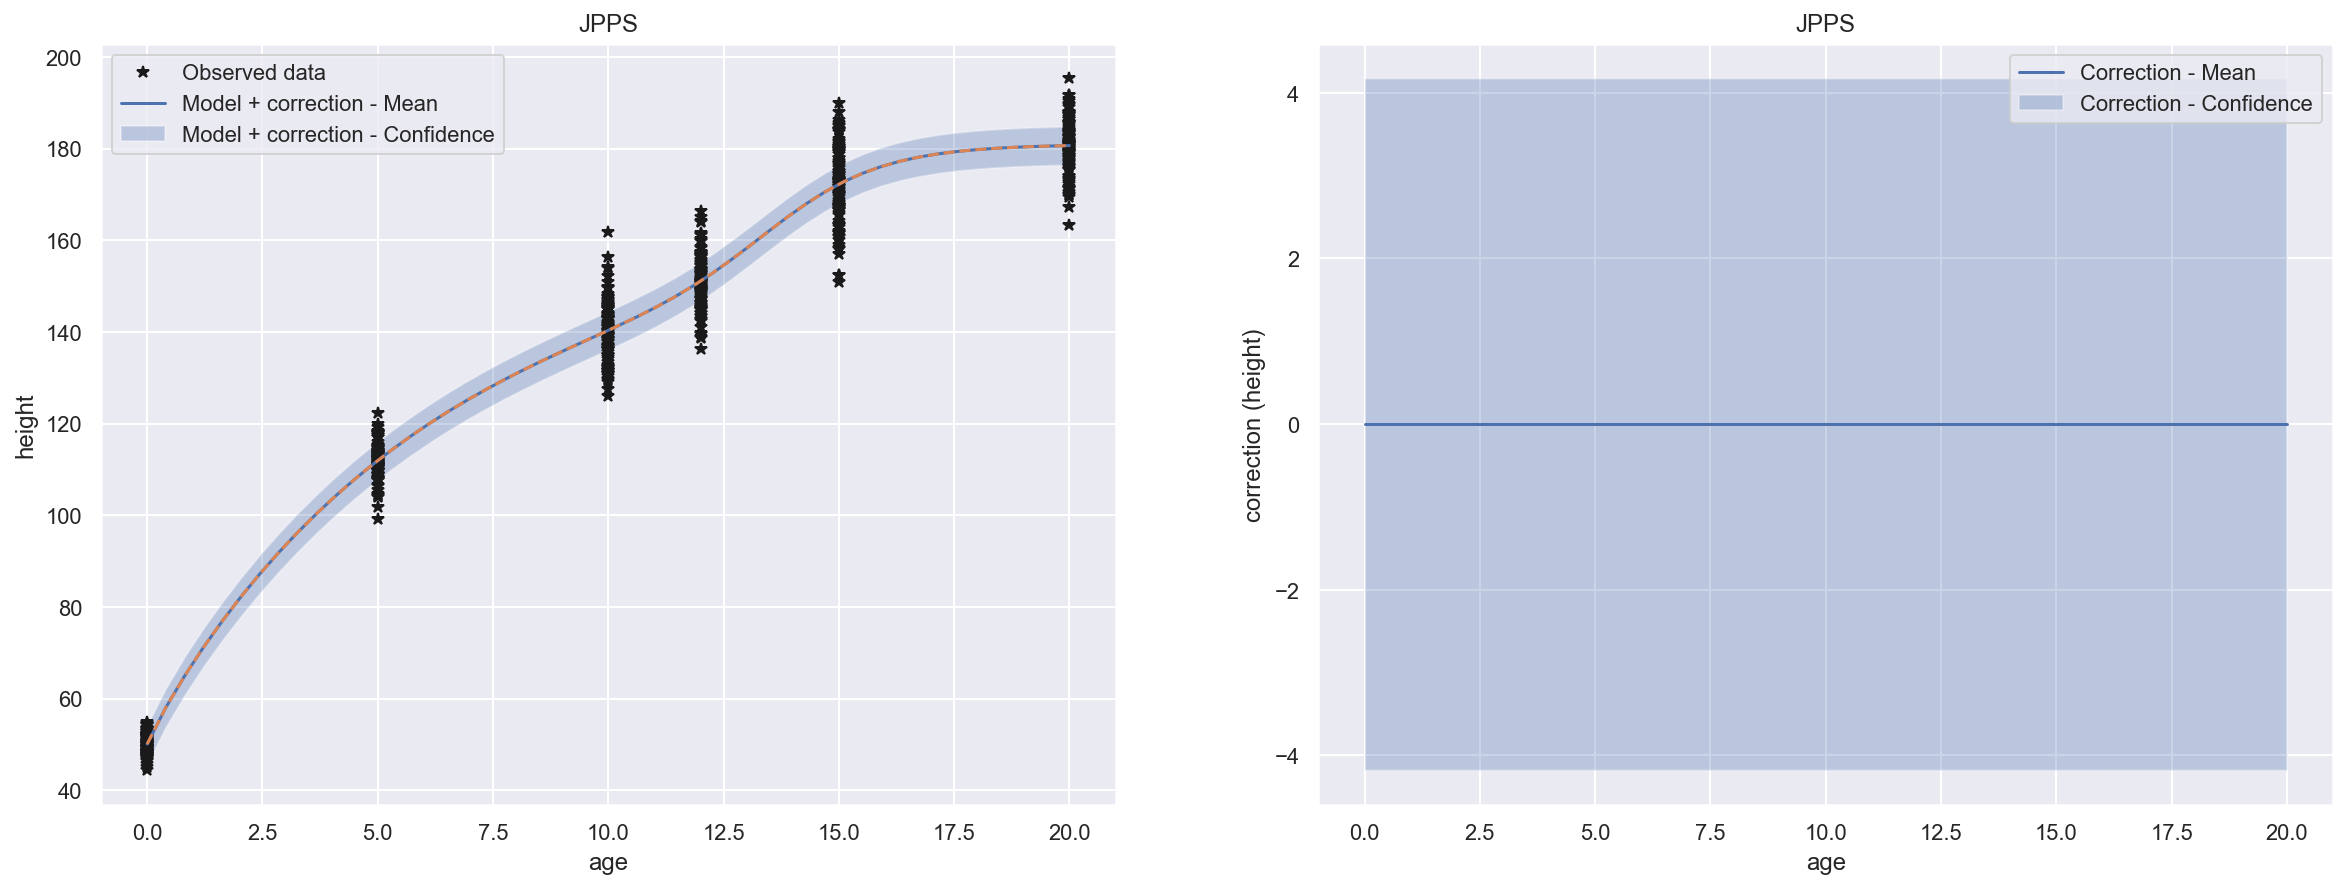

In [105]:
plot_discrepancy(data=data, model=model, likelihood=likelihood, m=m, theta=theta, title="JPPS");

## Using Lin

In [106]:
m = Linf
theta = res_linf.x

In [107]:
model, likelihood, hist_loss = train_discrepancy_model(data, m, theta)

  0%|          | 0/100 [00:00<?, ?it/s]

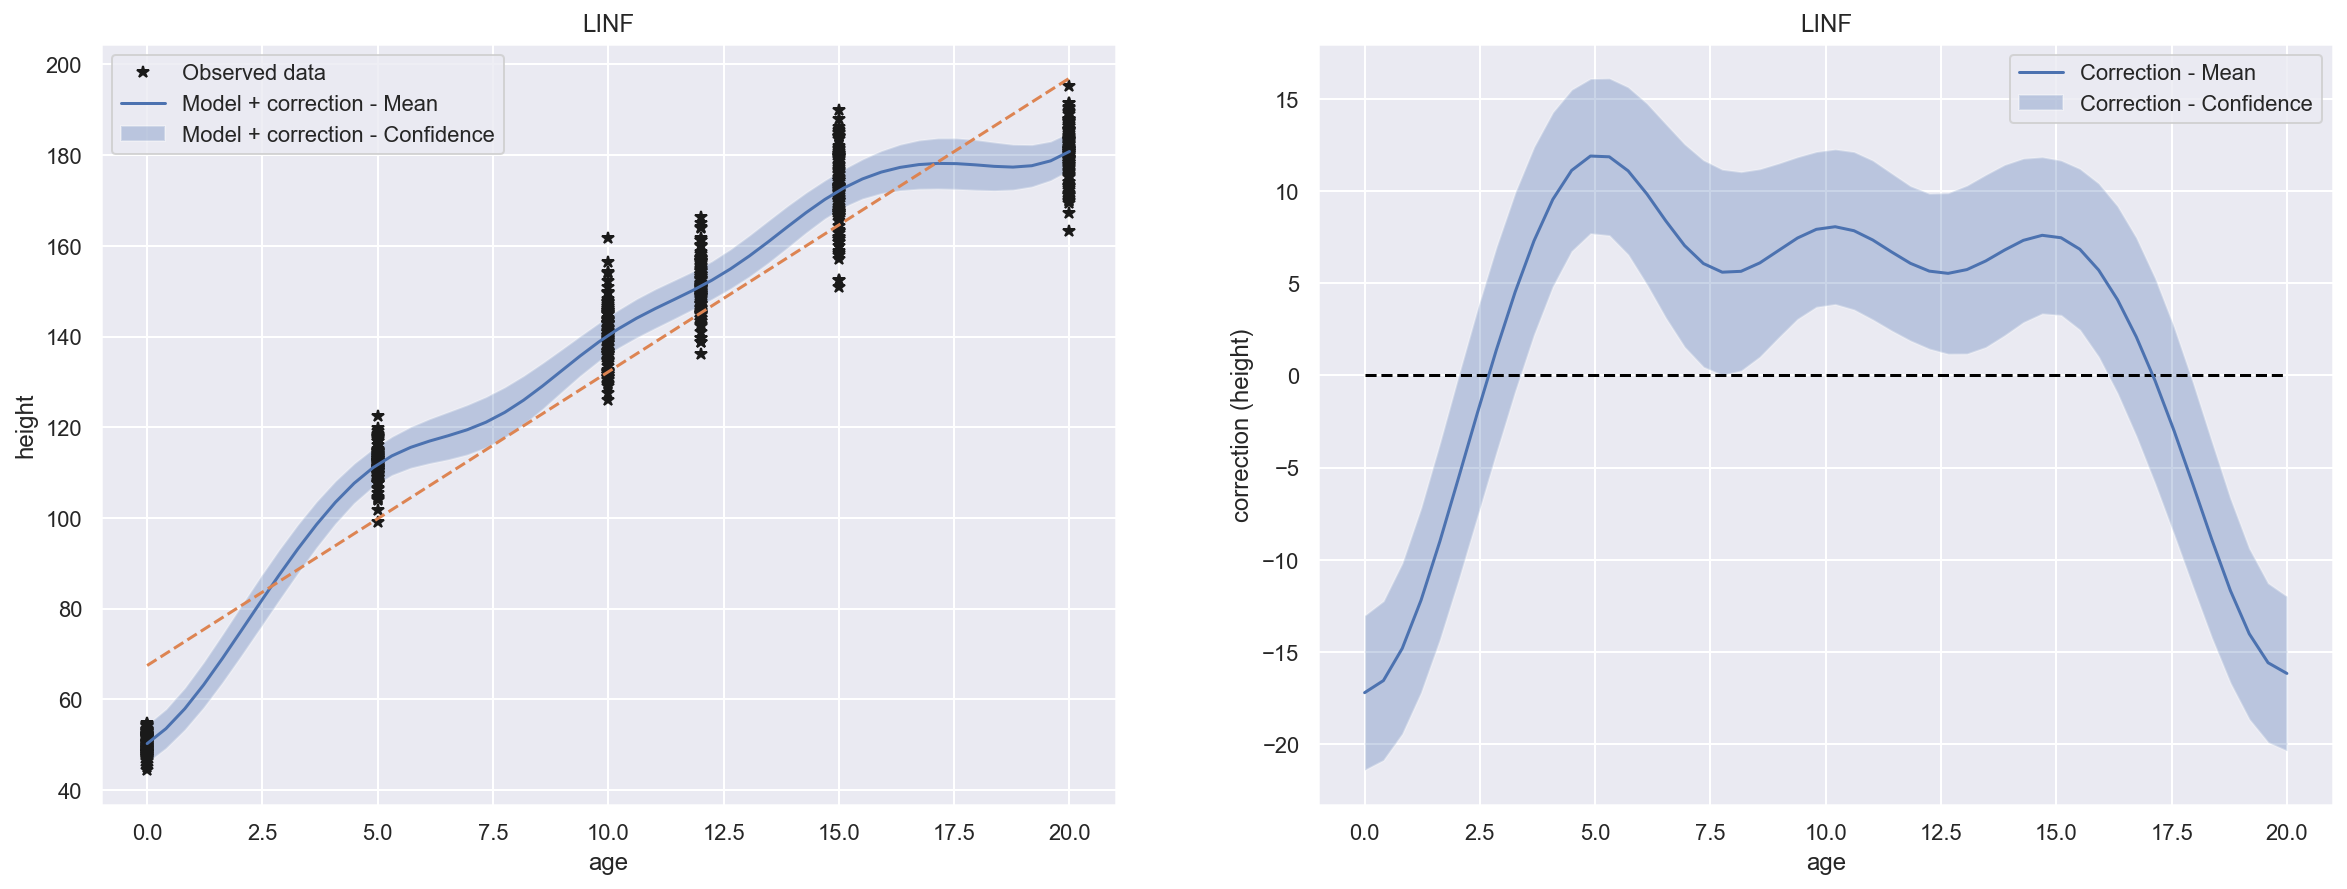

In [117]:
plot_discrepancy(data, model, likelihood, m, theta, title="LINF");

## Using Logf

In [118]:
m = Logf
theta = res_logf.x

In [119]:
model, likelihood, hist_loss = train_discrepancy_model(data, m, theta)

  0%|          | 0/100 [00:00<?, ?it/s]

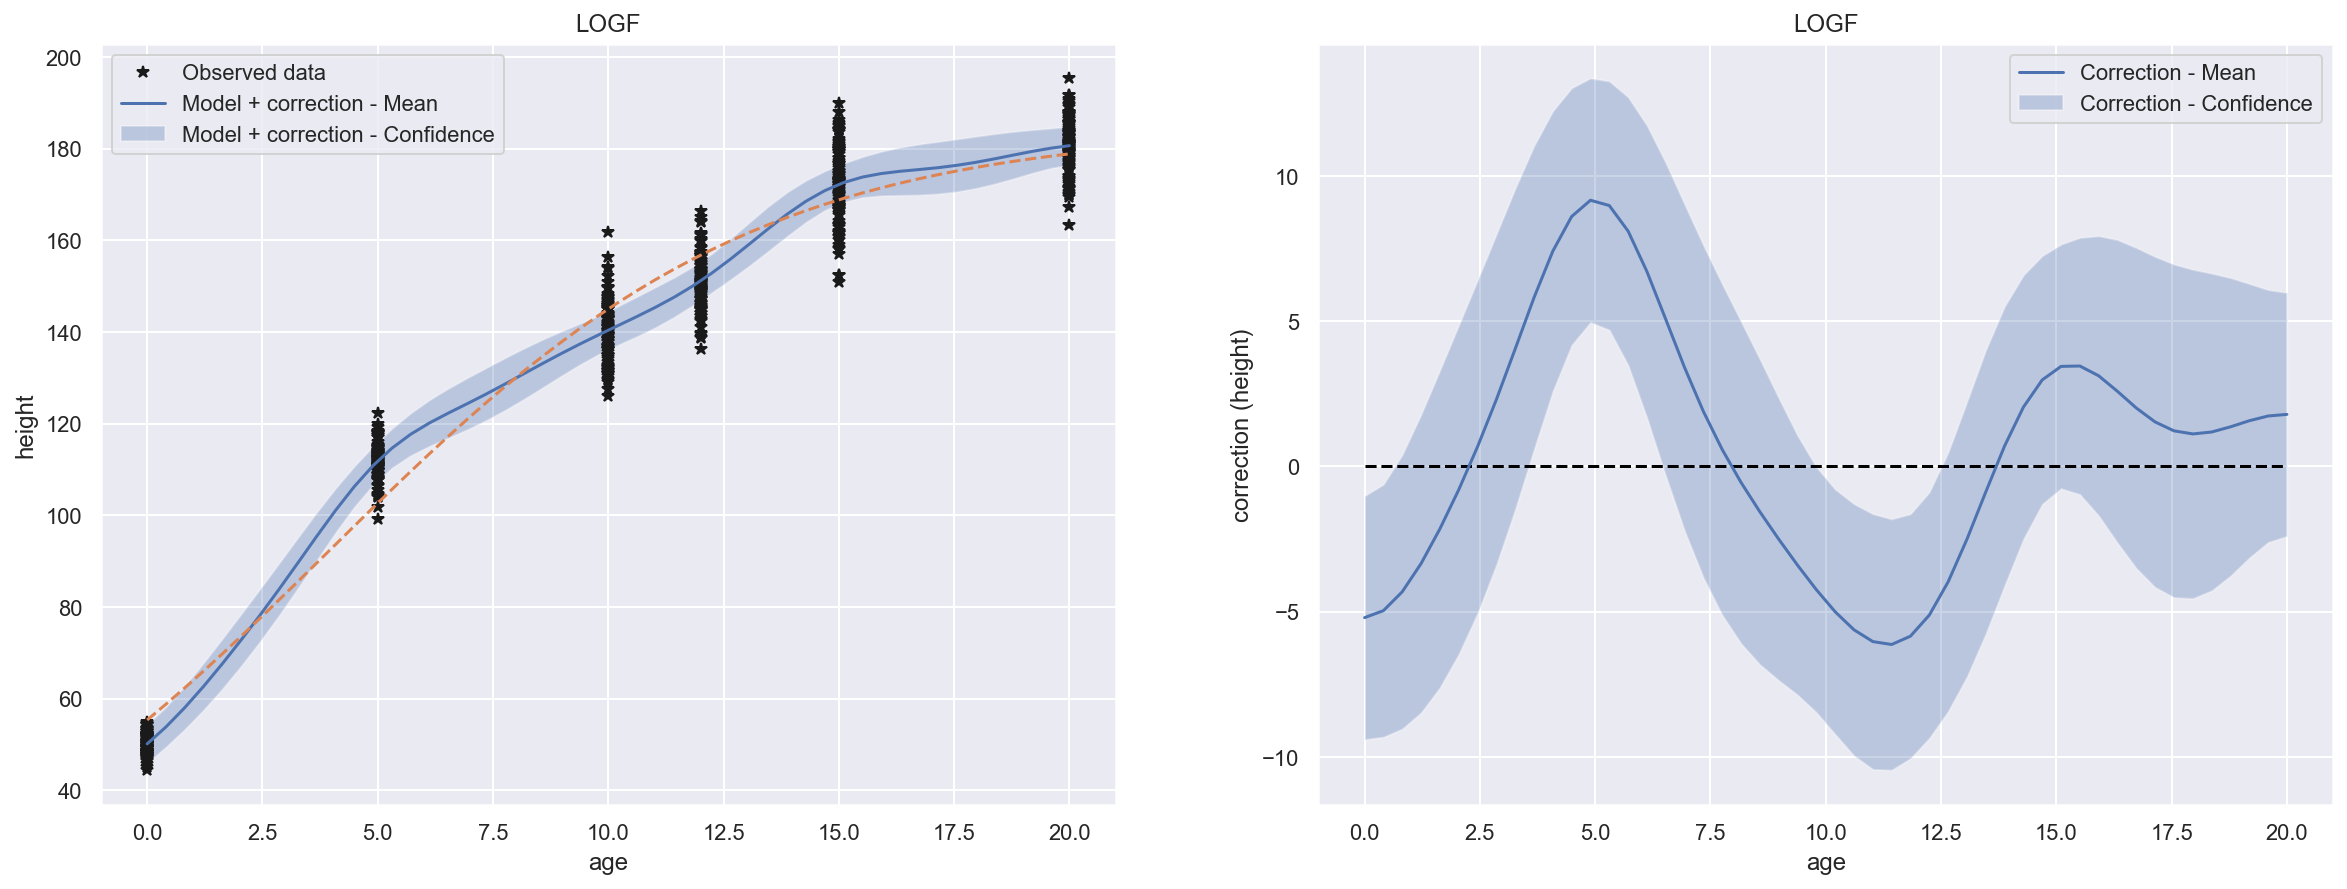

In [120]:
plot_discrepancy(data, model, likelihood, m, theta, title="LOGF");

## Using Pb

In [121]:
m = Pb
theta = res_pb.x

In [122]:
model, likelihood, hist_loss = train_discrepancy_model(data, m, theta)

  0%|          | 0/100 [00:00<?, ?it/s]

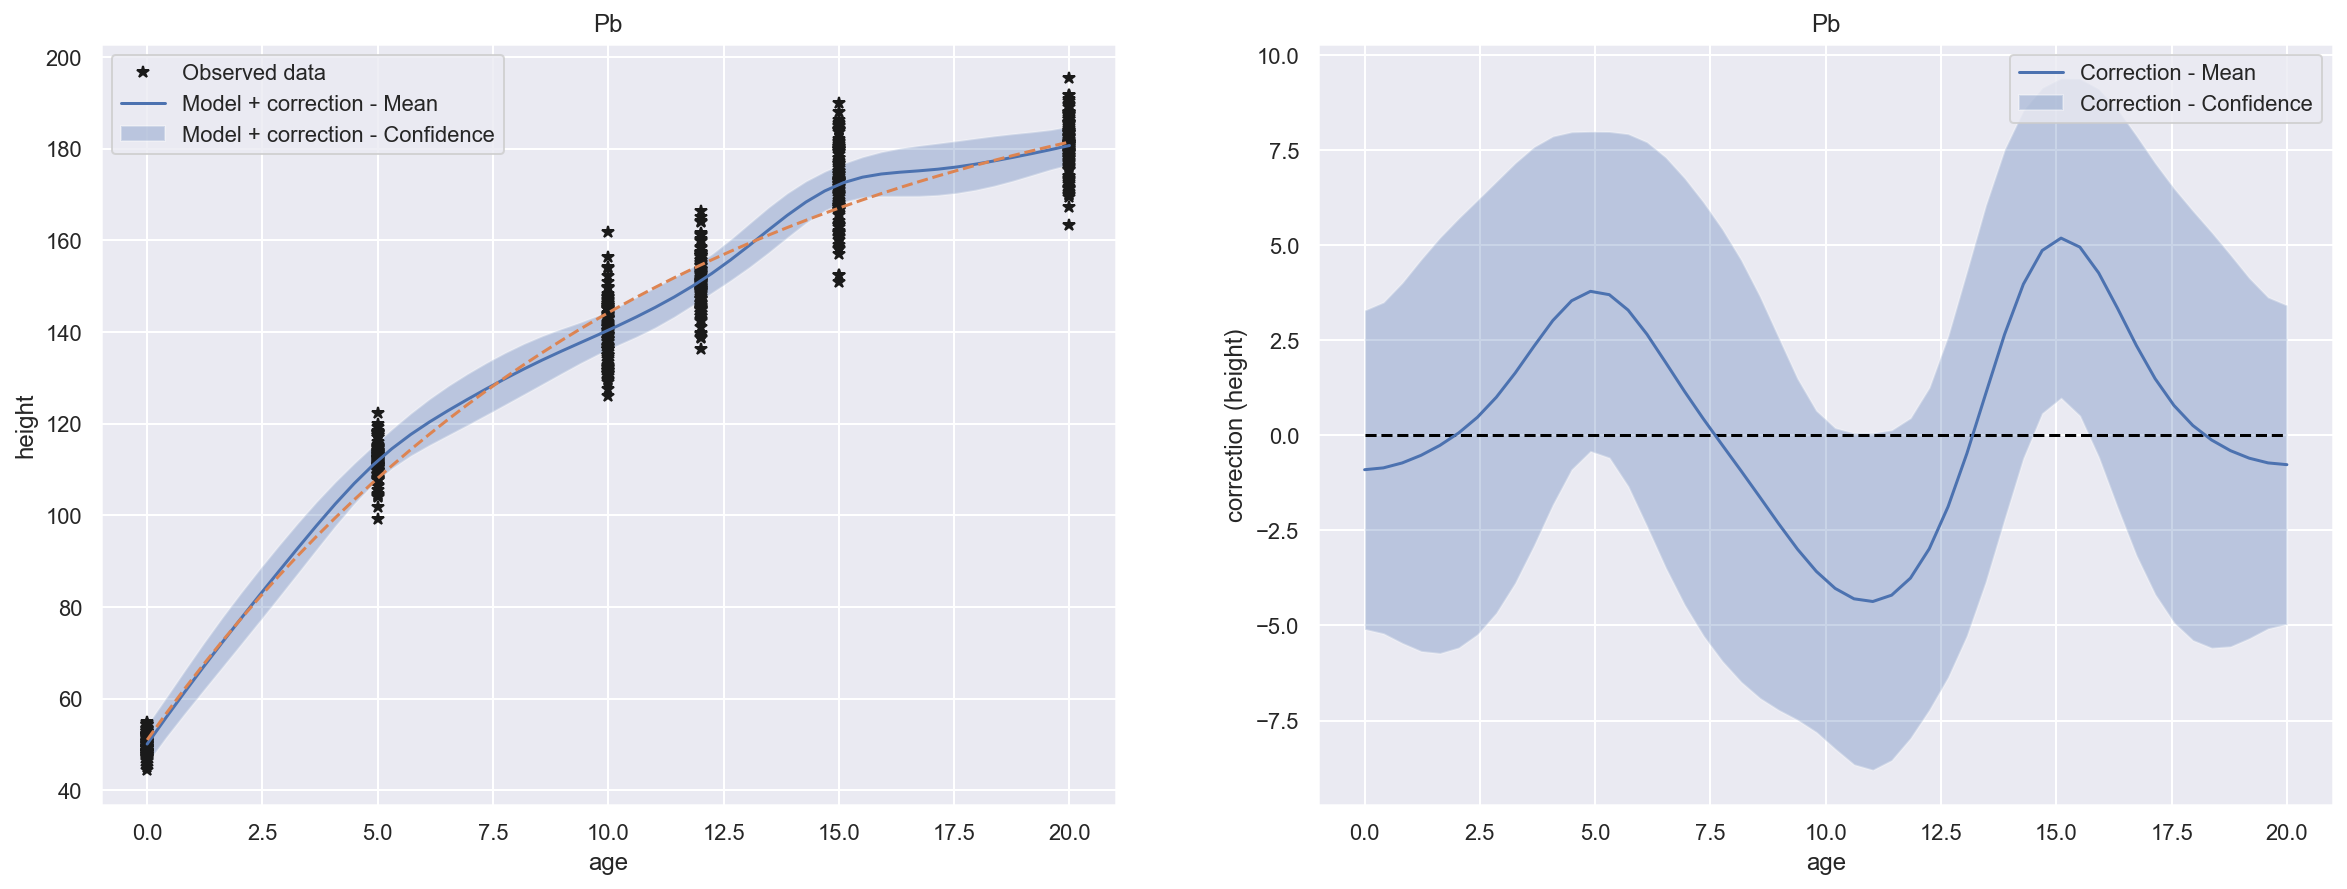

In [124]:
plot_discrepancy(data, model, likelihood, m, theta, title="Pb");

## Using SSC

In [125]:
m = Ssc
theta = res_ssc.x

In [126]:
model, likelihood, hist_loss = train_discrepancy_model(data, m, theta)

  0%|          | 0/100 [00:00<?, ?it/s]

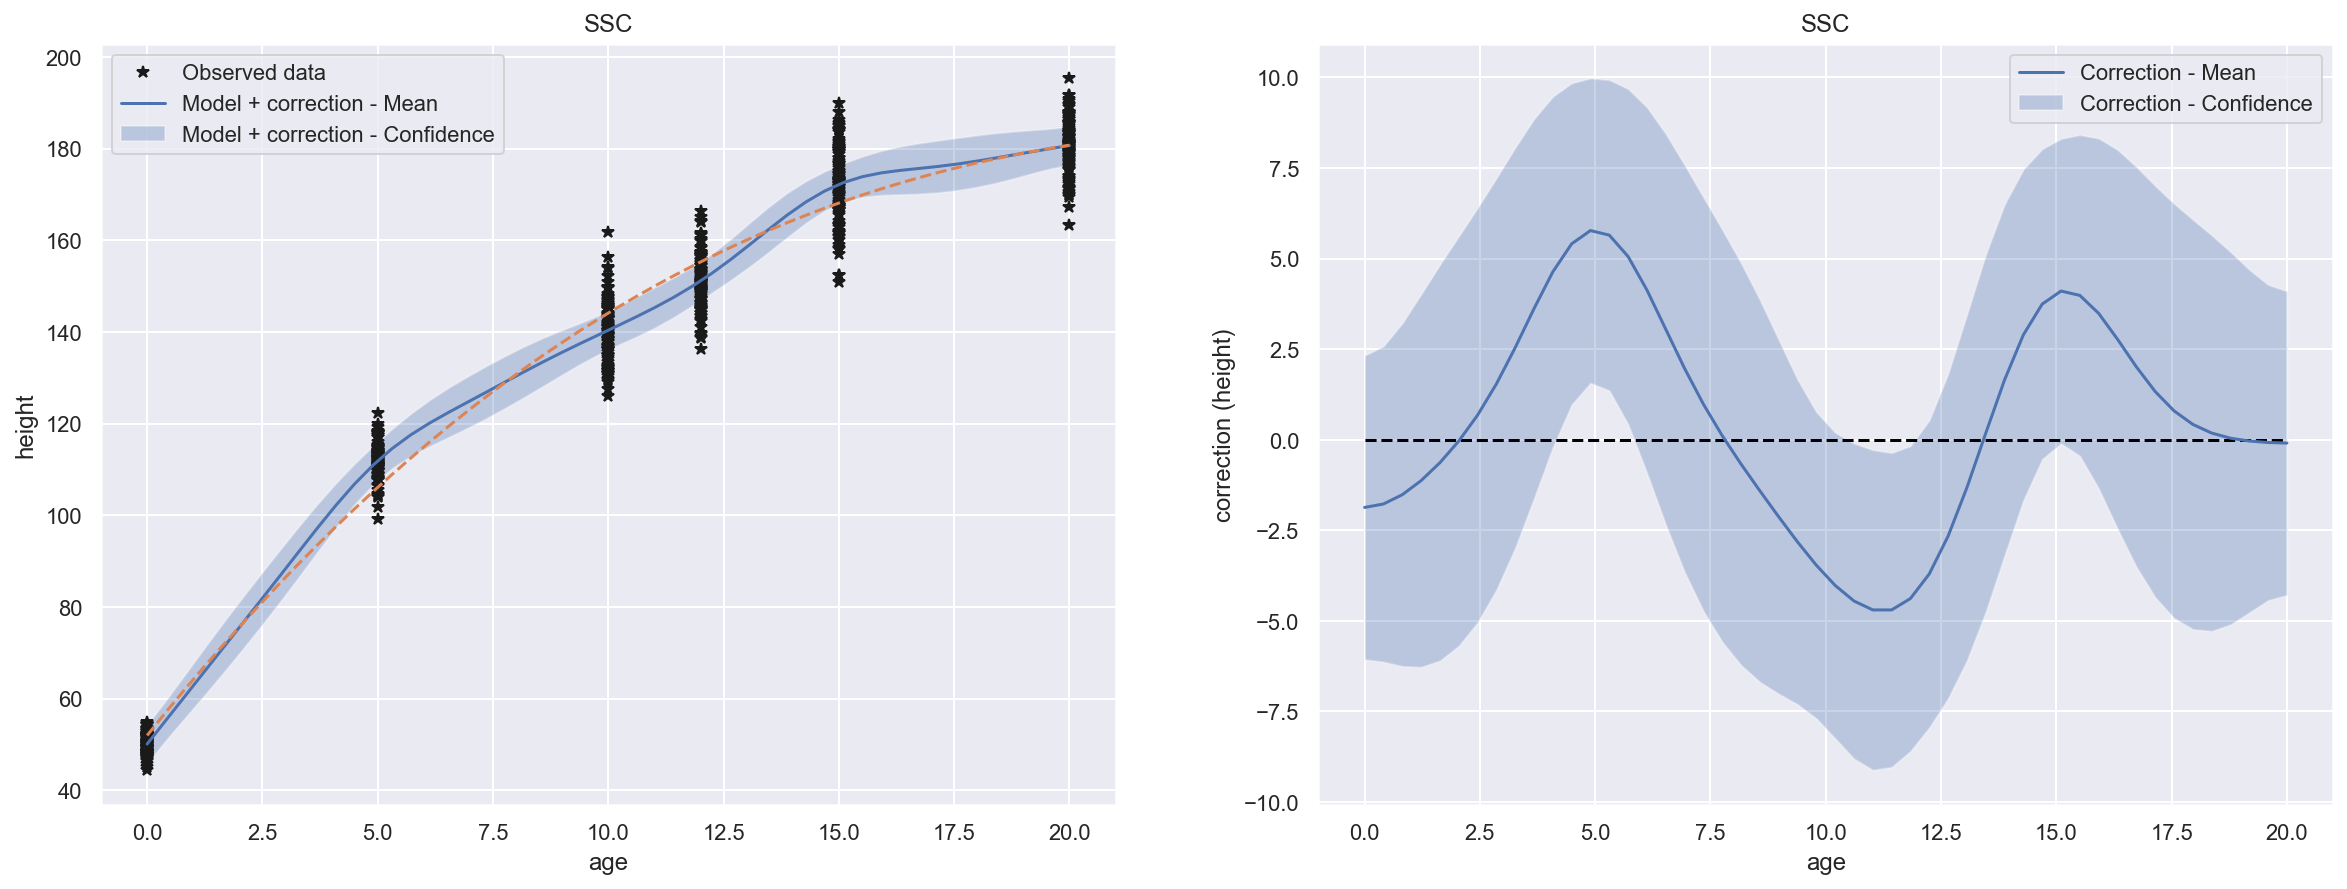

In [127]:
fig, ax = plot_discrepancy(data, model, likelihood, m, theta, title="SSC");